Import modules/packages for leave one out cross validation (LOOCV).

In [403]:
import os
import numpy as np
from numpy import mean, std
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random

Make output directory

In [404]:
cwd = os.getcwd()
path = cwd + "\output"
if not os.path.exists(path):
    os.mkdir(path)

Load data and assign response (y) and predictor (X) variables. 

In [405]:
#change file name (down20GSE26400ROC.txt) as needed
#file should contain ranking scores (e.g., T-score, NES, etc.) for items
#file must have column headers (1 for experimental and 0 for control samples) in row 1
#file must have row headers (gene or pathway IDs) in column A
df = pd.read_csv('GSE49996genedataneg.txt', delimiter = "\t", low_memory=False, header=None)

tempy = list(df.iloc[0])
tempy.pop(0)
y = np.array(tempy)

df = df.transpose()
df = df.reindex(df.index.drop(0)).reset_index(drop=True)
df2 = df.iloc[: , 1:]
querysize = len(df2.columns)
X = np.array(df2.values.tolist())

Assigning training and testing sets then performing LOOCV

In [406]:
loo = LeaveOneOut()
loo.get_n_splits(y)

88

In [407]:
dfprob = pd.DataFrame()
dfpredict = pd.DataFrame()
dfcoeff = pd.DataFrame()
xtestvallist = []
for train_index, test_index in loo.split(y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    cv = LeaveOneOut()
    
    model = LogisticRegression(solver='liblinear')
    clf = model.fit(X_train, y_train)
    temppredicted = model.predict(X_test)
    predicted = pd.Series(temppredicted)
    dfpredict = dfpredict.append(predicted, ignore_index=True)
    tempprobability = model.predict_proba(X_test)
    tempprobability = tempprobability[0]
    probability = pd.Series(tempprobability)
    dfprob = dfprob.append(probability, ignore_index=True)
    print('Probability y-axis for this sample is:')
    print(probability)
    print('Predicted experimental conditions for this sample', predicted[0])
    print('Actual experimental conditions for this sample', y_test)
    print()
    
    #returns coefficients for each gene in the logistic regression equation
    clfall = clf.coef_ 
    clfall = np.append(clfall, clf.intercept_)
    tempseries = pd.Series(clfall)
    dfcoeff = dfcoeff.append(tempseries, ignore_index=True)

    #calculates X_test value
    X_test1 = X_test[0]
    n = 0
    temptotal = 0
    for i in X_test1:
        temptotal = temptotal + (clfall[n] * i)
        n = n + 1
    temptotal = temptotal + clf.intercept_
    xtestvallist.append(float(temptotal))
        
dfpredict.to_csv('output\dfpredictdata.txt', sep='\t', index=True)
dfprob.to_csv('output\dfprobdata.txt', sep='\t', index=False)
dfcoeffavg = dfcoeff.mean(axis=0)
dfcoeffavg.to_csv('output\dfcoeffdata.txt', sep='\t', index=True)

Probability y-axis for this sample is:
0    0.99819
1    0.00181
dtype: float64
Predicted experimental conditions for this sample 0.0
Actual experimental conditions for this sample [0.]

Probability y-axis for this sample is:
0    0.219945
1    0.780055
dtype: float64
Predicted experimental conditions for this sample 1.0
Actual experimental conditions for this sample [0.]

Probability y-axis for this sample is:
0    0.992204
1    0.007796
dtype: float64
Predicted experimental conditions for this sample 0.0
Actual experimental conditions for this sample [0.]

Probability y-axis for this sample is:
0    0.867973
1    0.132027
dtype: float64
Predicted experimental conditions for this sample 0.0
Actual experimental conditions for this sample [0.]

Probability y-axis for this sample is:
0    0.99737
1    0.00263
dtype: float64
Predicted experimental conditions for this sample 0.0
Actual experimental conditions for this sample [0.]

Probability y-axis for this sample is:
0    0.999633
1    0

Probability y-axis for this sample is:
0    0.036525
1    0.963475
dtype: float64
Predicted experimental conditions for this sample 1.0
Actual experimental conditions for this sample [1.]

Probability y-axis for this sample is:
0    0.604463
1    0.395537
dtype: float64
Predicted experimental conditions for this sample 0.0
Actual experimental conditions for this sample [1.]

Probability y-axis for this sample is:
0    0.881964
1    0.118036
dtype: float64
Predicted experimental conditions for this sample 0.0
Actual experimental conditions for this sample [1.]

Probability y-axis for this sample is:
0    0.943664
1    0.056336
dtype: float64
Predicted experimental conditions for this sample 0.0
Actual experimental conditions for this sample [1.]

Probability y-axis for this sample is:
0    0.35315
1    0.64685
dtype: float64
Predicted experimental conditions for this sample 1.0
Actual experimental conditions for this sample [1.]

Probability y-axis for this sample is:
0    0.082465
1   

In [408]:
#reports performance via mean (and stdev) of accurate predicted sample conditions
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv)
print('Accuracy mean is', np.mean(scores))
print('Accuracy stdev is', np.std(scores))

Accuracy mean is 0.8295454545454546
Accuracy stdev is 0.37603163881305224


Time to visualize the results generated above

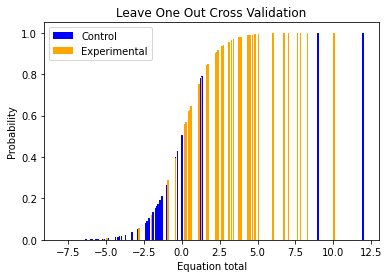

In [409]:
controlXvals = []
expXvals = []
controlYvals = []
expYvals = []
n = 0
for iter in dfprob[1]:
    if y[n] == 0:
        controlXvals.append(xtestvallist[n])
        controlYvals.append(iter)
    if y[n] == 1:
        expXvals.append(xtestvallist[n])
        expYvals.append(iter)
    n = n + 1
   
plt.title("Leave One Out Cross Validation")
plt.xlabel("Equation total")
plt.ylabel("Probability")
plt.bar(controlXvals, controlYvals, width=0.1, label='Control', color='blue')
plt.bar(expXvals, expYvals, width=0.1, label='Experimental', color='orange')
plt.legend(loc='best')
plt.show()